If run in colab, it's better to use T4 GPU

In [ ]:
import torch
import torchvision  # MNIST dataset
from torchvision import transforms  # transforms of source data
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Firstly let's check GPU or CPU used in system and save it into variable **device**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Next we need to load our dataset, classically it will be MNIST

In [ ]:
# for general case let's set composition of transformations
transform = transforms.Compose([transforms.ToTensor()])
# there it's just conversion of our data to tensor

# then we load train and test dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
# root - where are we wanna save it
# train - which wersion is needed train or test
# download - download data from the internet or it has been already downloaded
# transform - which transformations do we want to be done right after dataset is loaded

# So, data is loaded, then we are creating iterators in our data
trainiter = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testiter = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 127598612.92it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 50180486.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35659401.97it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4020795.43it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let's see what is the shape of our downloaded data

In [ ]:
trainiter.dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
testiter.dataset.data.shape

torch.Size([10000, 28, 28])

We can show our first picture like that

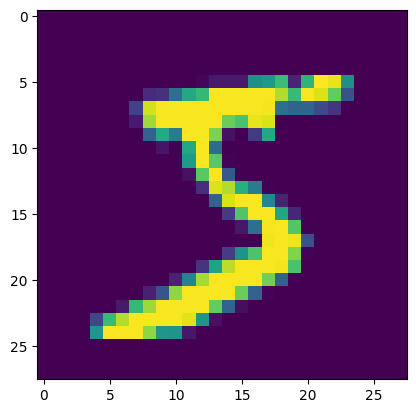

In [ ]:
plt.imshow(trainiter.dataset.data[0].numpy())

Or in a gary scale

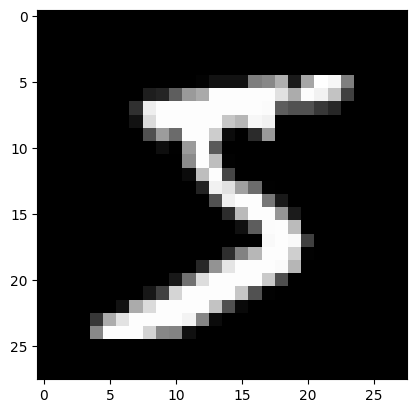

In [ ]:
plt.imshow(trainiter.dataset.data[0].numpy(), cmap='gray')

Now is time for our neural network class creation

In [ ]:
from torch import nn
from torch.nn import functional

In [ ]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # 256 is output value of last convolutional layer
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(functional.relu(self.conv1(x)))
        x = self.pool(functional.relu(self.conv2(x)))

        x = x.view(-1, 256)

        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = functional.softmax(self.fc3(x))

        return x



Let's create object of our CNN

In [ ]:
net = MyConvNet()

summary(net.cuda(), (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


<ipython-input-10-28b339067f21>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = functional.softmax(self.fc3(x))


In [ ]:
batch = next(iter(trainiter))

net.forward(torch.FloatTensor(batch[0]).cuda())

<ipython-input-10-28b339067f21>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = functional.softmax(self.fc3(x))


tensor([[0.1009, 0.0984, 0.1084, 0.1114, 0.0972, 0.0950, 0.1013, 0.0917, 0.0900,
         0.1057],
        [0.1010, 0.0984, 0.1081, 0.1115, 0.0965, 0.0959, 0.1004, 0.0924, 0.0903,
         0.1055],
        [0.1003, 0.0988, 0.1099, 0.1121, 0.0959, 0.0953, 0.1020, 0.0914, 0.0899,
         0.1044],
        [0.1000, 0.0984, 0.1089, 0.1124, 0.0954, 0.0962, 0.1009, 0.0925, 0.0901,
         0.1053]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Now it's time to learn our nn

In [ ]:
from tqdm.notebook import tqdm  # For progress bar

In [ ]:
net = net.to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # optimiser keeps link on parameters of our net and when we know parameters gradients we can use it's optimization
losses = []

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

<ipython-input-10-28b339067f21>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = functional.softmax(self.fc3(x))


[1,  2000] loss: 1.881
[1,  4000] loss: 1.609
[1,  6000] loss: 1.583
[1,  8000] loss: 1.567
[1, 10000] loss: 1.555
[1, 12000] loss: 1.547
[1, 14000] loss: 1.544


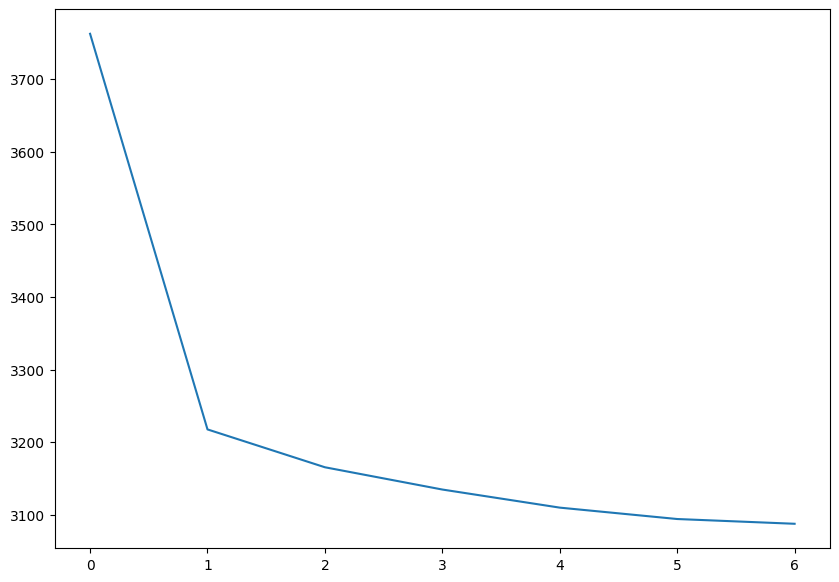

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 1.527
[2,  4000] loss: 1.524
[2,  6000] loss: 1.517
[2,  8000] loss: 1.518
[2, 10000] loss: 1.513
[2, 12000] loss: 1.513
[2, 14000] loss: 1.510
Обучение закончено


In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

for epoch in tqdm(range(2)):

    running_loss = 0.0

    for i, batch in enumerate(tqdm(trainiter)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch.to(device))  # we created prediction and saved it's history to it
        loss = loss_function(y_pred, y_batch.to(device))  # then in loss function we made one more change for tensor and saved it too
        loss.backward()  # there we acquire derivative of our loss function
        optimizer.step()  # And then we use that derivative in optimizer to make adam gradient descent

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

<ipython-input-10-28b339067f21>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = functional.softmax(self.fc3(x))


Value: 7
Value: 4
Value: 5
Value: 9
Value: 9
Value: 9
Value: 4
Value: 0
Value: 3
Value: 7


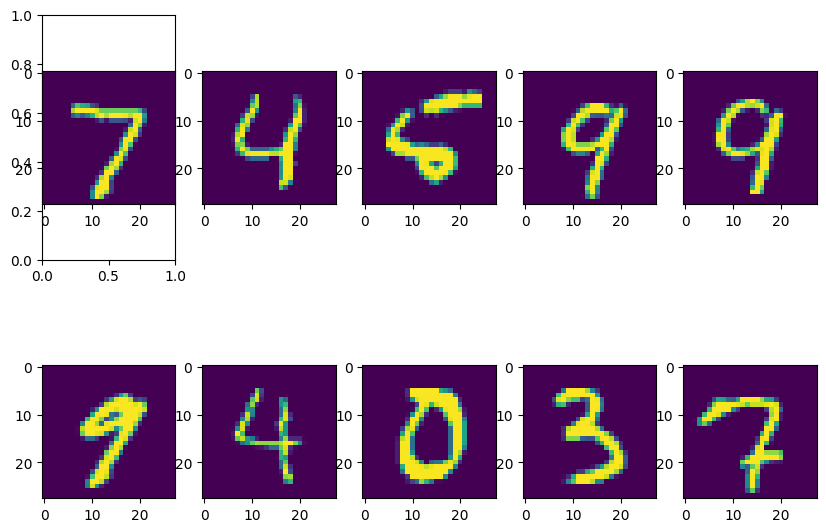

In [ ]:
i = 0

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(2, 5, 1)

for batch in testiter:
    i += 1
    ax = fig.add_subplot(2, 5, i)
    x, y = batch
    _, predicted = torch.max(net(x.to(device)), 1)
    print("Value:", int(predicted[0]))
    ax.imshow(x[0][0][:][:].numpy());
    if i == 10:
        break


In [ ]:
classes = tuple(str(i) for i in range(10))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testiter:
        images, labels = data
        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)

        c = (predicted.cpu().detach() == labels)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

<ipython-input-10-28b339067f21>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = functional.softmax(self.fc3(x))


Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 97 %
Accuracy of     3 : 91 %
Accuracy of     4 : 97 %
Accuracy of     5 : 94 %
Accuracy of     6 : 97 %
Accuracy of     7 : 94 %
Accuracy of     8 : 93 %
Accuracy of     9 : 94 %
